In [25]:
import random

import matplotlib.pyplot as plt
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, VerticalFlip, Crop, PixelDropout, CropAndPad, RandomBrightnessContrast
)
import config
import paths
import randomness
from cnn_builder import *
from config import *
from dataset_functions import *
from functools import partial
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import random
import randomness
import rendering
import training_history

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

%load_ext autoreload
%autoreload 2
%pylab inline

read_json_config(paths.config_file, network_type=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['random', 'shuffle', 'inf', 'copy']
`%matplotlib` prevents importing * from pylab and numpy



In [26]:
font_mapping = {'family': 'Palatino Linotype', 'weight': 'normal', 'size': 11}
plt.rc('font', **font_mapping)

In [27]:
inf = 2e32
sampling_strategy = 'not minority'

network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type) + '_indian_pines'

In [36]:
config.batch_size = 512

Max class: 255
Class 0: 46
Class 1: 1428
Class 2: 830
Class 3: 237
Class 4: 483
Class 5: 730
Class 6: 28
Class 7: 478
Class 8: 20
Class 9: 972
Class 10: 2455
Class 11: 593
Class 12: 205
Class 13: 1265
Class 14: 386
Class 15: 93
Class 255: 10776
Hypercube shape: (145, 145, 200)
{255: 0, 2: 1, 14: 2, 10: 3, 11: 4, 4: 5, 9: 6, 13: 7, 15: 8, 1: 9, 3: 10, 7: 11, 5: 12, 8: 13, 0: 14, 6: 15, 12: 16}


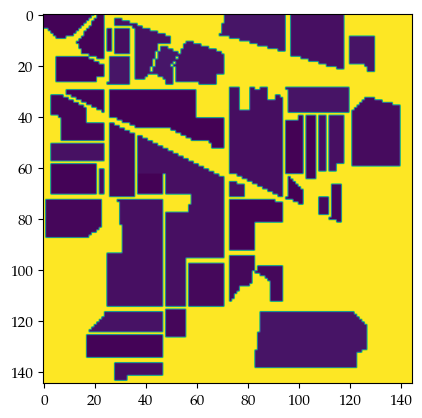

Min: 955.0, Max: 9604.0, Size: (145, 145, 200)
Max class: 255


In [49]:
hc_umat, max_class = load_indian_pines_umat(plot_hc=False, plot_mask=True)
hc_umat.print_metadata()
print("Max class: " + str(max_class))

In [50]:
hc_set = HypercubeSet([hc_umat])
hc_set.print_num_samples()

Number of samples per class:
Class 0: 10776
Class 1: 830
Class 2: 386
Class 3: 2455
Class 4: 593
Class 5: 483
Class 6: 972
Class 7: 1265
Class 8: 93
Class 9: 1428
Class 10: 237
Class 11: 478
Class 12: 730
Class 13: 20
Class 14: 46
Class 15: 28
Class 16: 205


In [51]:
hc_set.identify_ground_samples()
hc_set.split_hypercubes(test_percentage=config.test_split)
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Train size: 8711, Test size: 1538
|████████████████████████████████████████| 4/4 [100%] in 1.7s (1.98/s)                                                  


(FactorAnalysis(n_components=40, random_state=42), StandardScaler())

In [52]:
num_classes = hc_set.get_num_classes() - 1
img_shape = (config.patch_size, config.patch_size, config.num_target_features)

In [53]:
transforms = Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Rotate(limit=(-360, -360), p=0.1),
            Rotate(limit=(-270, -270), p=0.1),
            Rotate(limit=(-180, -180), p=0.1),
            Rotate(limit=(-90, -90), p=0.1),
            Rotate(limit=(90, 90), p=0.1),
            Rotate(limit=(180, 180), p=0.1),
            Rotate(limit=(270, 270), p=0.1)
        ])

In [54]:
model = build_network(network_type=network_type, num_classes=num_classes, image_dim=img_shape)
compile_network(model, network_type, network_name, num_classes, show_summary=True, render_image=True)

{'optimizer': <keras.optimizers.optimizer_v2.rmsprop.RMSprop object at 0x00000285DCF2E7C0>, 'callbacks': [], 'intermediate_activation': 'relu', 'kernel_size': 3, 'start_size': 16, 'strides': 2}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23, 23, 40)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape (Reshape)              (None, 529, 40)      0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 529, 40)      0           ['reshape[0][0]']                

In [55]:
X_train, y_train = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping, train=True, start_percentage=0, end_percentage=1)

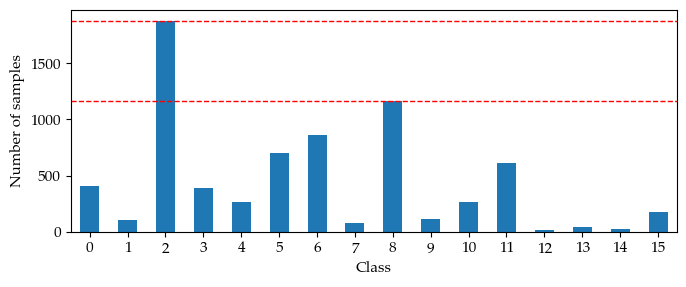

In [56]:
render_mask_histogram(y_train)

In [45]:
history = training_history.TrainingHistory(accuracy_name='sparse_categorical_accuracy')
callbacks, time_callback = get_callback_list(model_name=network_name, test_id=100)

In [46]:
max_samples = 100000
starting_index = 0

while True:
    X_train, y_train = hc_set.split_train(patch_size=config.patch_size, max_train_samples=max_samples,
                                          starting_index=starting_index, remove=False)

    if len(X_train) > 0:
        y_train = reduce_labels_center(y_train)
        X_train, y_train = remove_labels(X_train, y_train, [ground_label])
        #(patch, patch_label), _, _ = balance_classes(X_train, y_train, reduce=True, clustering=False, strategy=sampling_strategy)
        patch, patch_label = X_train, y_train

        # Remove patches with label 255
        # indices = np.where(patch_label != 255)
        # patch = patch[indices]
        # patch_label = patch_label[indices]

        #rendering.render_mask_histogram(patch_label)

        X_train_augment, y_train_augmented = augment_chunks(patch, patch_label)
        history.append_history(run_model(model, X_train_augment, y_train_augmented,
                                         validation_split=validation_split, callbacks=callbacks).history,
                               training_callback=time_callback, samples=X_train_augment)

        del X_train_augment, y_train_augmented
        del patch, patch_label
    else:
        break

    del X_train, y_train
    starting_index += max_samples

    gc.collect()

|████████████████████████████████████████| 14717/14717 [100%] in 0.1s (244269.67/s)                                     
Training for 100 epochs with batch size of 512...
Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 1.8039 - sparse_categorical_accuracy: 0.4512
Epoch 1: val_loss improved from inf to 2.05979, saving model to results/network\allopezr_2d_23x22_16_indian_pines_100.h5
52/52 [==============================] - 15s 220ms/step - loss: 1.8039 - sparse_categorical_accuracy: 0.4512 - val_loss: 2.0598 - val_sparse_categorical_accuracy: 0.5836
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 1.0116 - sparse_categorical_accuracy: 0.6796
Epoch 2: val_loss improved from 2.05979 to 1.39365, saving model to results/network\allopezr_2d_23x22_16_indian_pines_100.h5
52/52 [==============================] - 7s 137ms/step - loss: 1.0116 - sparse_categorical_accuracy: 0.6796 - val_loss: 1.3937 - val_sparse_categorical_accuracy: 0.7786
Epoch 3/100
51/5

In [47]:
test_prediction_prob = model.predict(X_test)
test_prediction = np.argmax(test_prediction_prob, axis=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

3/3 [==============================] - 0s 5ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9875
Test Loss: 0.043650537729263306, Test Accuracy: 0.987500011920929
